## SNAP proxy search for SNPs in LD with lead SNPs

1. Navigate to [SNAP Proxy Search](https://www.broadinstitute.org/mpg/snap/ldsearch.php)
+ Enter lead SNPs of interest under "Query SNPs"
+ Under "Search Options" set
  + SNP data set: 1000 Genomes Pilot 1
  + Population panel: CEU
  + r2 threshold: 0.5
  + Distance limit: 500
+ Under "Ouput Options"
  + Download to: File
  + Select "Include each query snp as a proxy for itself"
  + Select "Suppress warning messages in output"
+ Under "Filter By Array" make sure all are unselected
+ Under "Output Columns" select all besides "Associated Gene Annotations from GeneCruiser (decreases performance)"

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [2]:
# Read SNAP proxy search
path = 'data/snap/do-slim-proxy-SNPs.tsv.gz'
snap_df = pandas.read_table(path, compression='gzip', na_values=['N/A'])
snap_df.head()

,SNP,Proxy,Distance,RSquared,DPrime,Arrays,Chromosome,Coordinate_HG18,RecombinationRate,GeneticMapDistance,GeneticMapPosition,Major,Minor,MAF,NObserved
0,rs1198588,rs1198588,0,1.000,1,"AN,A5,A6,ICA,ICB",chr1,98325420,0.27184,0.00000,131.11046,T,A,0.242,120
1,rs1198588,rs1782812,5330,0.955,1,"AN,A5,A6,I3,I5,I6,I6Q,IM,IMD,IC,ICQ,IWQ,O54,O5...",chr1,98320090,0.26964,0.00157,131.10889,G,A,0.233,120
2,rs1198588,rs1198581,22273,0.911,1,"CYT,OQ,OE,O24,O28,O54,O5E,OEE",chr1,98303147,0.30153,0.00611,131.10435,C,T,0.225,120
3,rs1198588,rs2660299,24380,0.911,1,"A6,OQ,OE,O24,O28,O54,O5E,OEE,ICA,ICB",chr1,98301040,0.16161,0.00648,131.10398,T,C,0.225,120
4,rs1198588,rs2660300,24621,0.911,1,"I3,I5,I6,I6Q,IM,IMD,IC,ICQ,IWQ,O54,O5E,ICA,ICB",chr1,98300799,0.15214,0.00652,131.10394,C,A,0.225,120


In [15]:
# Condense SNAP proxy search by lead SNP and compute windows
snap_errors = list()

rows = list()
for snp, group_df in snap_df.groupby('SNP', as_index=False):
    try:
        lead = group_df[group_df.Proxy == snp].iloc[0]
    except IndexError:
        snap_errors.append(snp)
        continue
    
    row = pandas.Series()
    row['lead_snp'] = snp
    row['lead_chrom'] = lead['Chromosome']
    row['lead_coord'] = lead['Coordinate_HG18']
    row['lead_maf'] = lead['MAF']
    
    window_df = group_df[(group_df.Chromosome == row['lead_chrom']) & (group_df.RSquared >= 0.8)]
    i_min = numpy.argmin(list(window_df.Coordinate_HG18))
    i_max = numpy.argmax(list(window_df.Coordinate_HG18))
    for side, i in ('lower', i_min), ('upper', i_max):
        window = window_df.iloc[i]
        row[side + '_snp'] = window.Proxy
        row[side + '_coord'] = window.Coordinate_HG18
        row[side + '_map_dist'] = window.GeneticMapDistance
        row[side + '_maf'] = window.MAF
    
    row['span_kb'] = (row['upper_coord'] - row['lower_coord']) / 1000
    row['span_cM'] = row['lower_map_dist'] + row['upper_map_dist']
    rows.append(row)

window_df = pandas.DataFrame(rows)
len(snap_errors)

38

In [16]:
window_df.head()

,lead_snp,lead_chrom,lead_coord,lead_maf,lower_snp,lower_coord,lower_map_dist,lower_maf,upper_snp,upper_coord,upper_map_dist,upper_maf,span_kb,span_cM
0,rs1000113,chr5,150220269,0.042,rs76767593,150150036,0.04616,0.042,rs73268545,150315475,0.02666,0.042,165.439,0.07282
1,rs1000579,chr4,4770395,0.442,rs1000579,4770395,0.00000,0.442,rs10012526,4778062,0.00758,0.425,7.667,0.00758
2,rs1000589,chr13,63039914,0.450,rs672064,62935367,0.05226,0.483,rs7323601,63042754,0.00090,0.450,107.387,0.05316
3,rs1000597,chr7,30903703,0.100,rs10229128,30899051,0.01045,0.100,rs1000597,30903703,0.00000,0.100,4.652,0.01045
4,rs10007052,chr4,142225023,0.183,rs28529555,142224374,0.00013,0.183,rs11734545,142231391,0.00587,0.175,7.017,0.00600


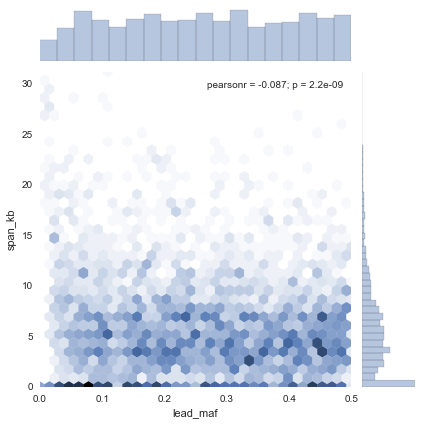

In [19]:
# View window span (kilobases) versus minor allele frequency
seaborn.jointplot(window_df.lead_maf, numpy.sqrt(window_df.span_kb), kind='hex');

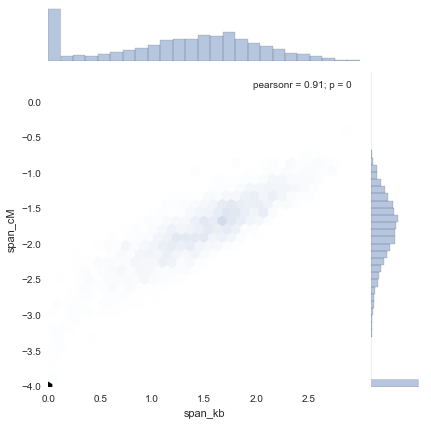

In [25]:
# View window span (kilobases) versus span (centimorgans)
seaborn.jointplot(numpy.log10(1 + window_df.span_kb), numpy.log10(0.0001 + window_df.span_cM), kind='hex');